# Deep Learning Approach - Comprehensive EDA for Neural Networks

## Adult Income Classification with Deep Learning Focus

This notebook conducts in-depth exploratory data analysis specifically designed for deep learning approaches to income classification. We focus on:

1. **Correlation and Multicollinearity Analysis** - Understanding feature relationships for neural network design
2. **Feature Sparsity and Class Imbalance** - Critical factors for deep learning performance
3. **Feature Interactions** - Exploring complex relationships that neural networks can capture
4. **Deep Learning Data Preparation** - Specialized preprocessing for neural networks

### Key Questions for Deep Learning:
- Which features have high multicollinearity that might cause training instability?
- How sparse are our categorical features after encoding?
- What feature interactions exist that neural networks should learn?
- How should we handle class imbalance for optimal neural network training?

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, pointbiserialr

# Preprocessing for deep learning
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Visualization settings
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully")
print("Ready for deep learning EDA")

Libraries imported successfully
Ready for deep learning EDA


## 1. Data Loading and Initial Assessment

In [2]:
# Load the dataset
df = pd.read_csv('data/adult.csv')

print("DATASET OVERVIEW FOR DEEP LEARNING")
print("="*50)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumn types:")
print(df.dtypes.value_counts())

# Quick data quality check
print(f"\nData Quality Assessment:")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check for '?' values (missing data indicators)
question_mark_cols = []
for col in df.select_dtypes(include=['object']).columns:
    if (df[col] == '?').any():
        count = (df[col] == '?').sum()
        pct = count / len(df) * 100
        question_mark_cols.append((col, count, pct))
        print(f"'{col}' has {count} '?' values ({pct:.1f}%)")

df.head()

DATASET OVERVIEW FOR DEEP LEARNING
Dataset shape: (32561, 15)
Memory usage: 17.65 MB

Column types:
object    9
int64     6
Name: count, dtype: int64

Data Quality Assessment:
Missing values: 0
Duplicate rows: 24
'workclass' has 1836 '?' values (5.6%)
'occupation' has 1843 '?' values (5.7%)
'native.country' has 583 '?' values (1.8%)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


TARGET VARIABLE ANALYSIS
Class Distribution:
  <=50K: 24,720 (75.9%)
  >50K: 7,841 (24.1%)

Class Imbalance Analysis:
Imbalance ratio: 3.15:1
Minority class: 7,841 samples
Majority class: 24,720 samples
   Recommendations for neural networks:
   - Use weighted loss functions
   - Consider focal loss
   - Monitor precision/recall during training
   - Use stratified sampling


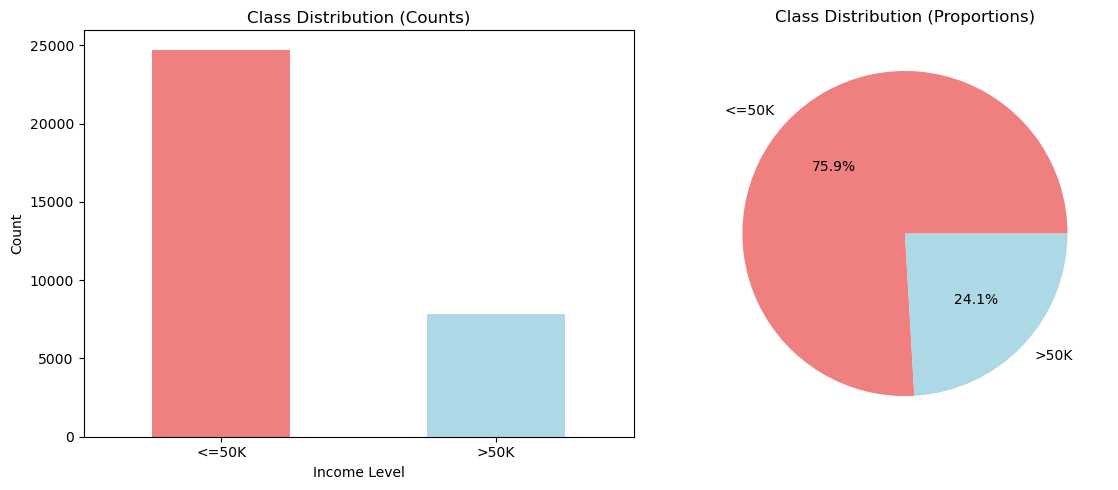

In [3]:
# Target variable analysis - Critical for neural network design
print("TARGET VARIABLE ANALYSIS")
print("="*40)

target_dist = df['income'].value_counts()
target_props = df['income'].value_counts(normalize=True)

print("Class Distribution:")
for cls, count in target_dist.items():
    pct = target_props[cls] * 100
    print(f"  {cls}: {count:,} ({pct:.1f}%)")

# Class imbalance ratio - important for loss function design
minority_class = target_dist.min()
majority_class = target_dist.max()
imbalance_ratio = majority_class / minority_class

print(f"\nClass Imbalance Analysis:")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Minority class: {minority_class:,} samples")
print(f"Majority class: {majority_class:,} samples")

if imbalance_ratio > 2:
    print("WARNING: SIGNIFICANT CLASS IMBALANCE DETECTED")
    print("   Recommendations for neural networks:")
    print("   - Use weighted loss functions")
    print("   - Consider focal loss")
    print("   - Monitor precision/recall during training")
    print("   - Use stratified sampling")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
target_dist.plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightblue'])
axes[0].set_title('Class Distribution (Counts)')
axes[0].set_xlabel('Income Level')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Pie chart
target_props.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                  colors=['lightcoral', 'lightblue'])
axes[1].set_title('Class Distribution (Proportions)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 2. In-Depth Correlation and Multicollinearity Analysis

Understanding correlations is crucial for neural network design:
- High correlations between features can lead to redundant learning
- Multicollinearity can cause training instability
- Correlation with target helps with feature importance

In [4]:
# Prepare data for correlation analysis
print("CORRELATION AND MULTICOLLINEARITY ANALYSIS")
print("="*60)

# Create a working copy and handle missing values
df_corr = df.copy()
df_corr = df_corr.replace('?', np.nan)

# Fill missing values for correlation analysis
for col in df_corr.select_dtypes(include=['object']).columns:
    if df_corr[col].isnull().any():
        mode_val = df_corr[col].mode()[0]
        df_corr[col].fillna(mode_val, inplace=True)

# Create binary target variable
df_corr['income_binary'] = (df_corr['income'] == '>50K').astype(int)

# Encode categorical variables for correlation analysis
le = LabelEncoder()
categorical_cols = df_corr.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('income')  # Remove original income column

df_encoded = df_corr.copy()
for col in categorical_cols:
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])

# Get numerical columns for analysis
numerical_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()
encoded_categorical_cols = [col + '_encoded' for col in categorical_cols]
all_numeric_cols = numerical_cols + encoded_categorical_cols

print(f"Analyzing correlations for {len(all_numeric_cols)} features")
print(f"Original numerical: {len(numerical_cols)}")
print(f"Encoded categorical: {len(encoded_categorical_cols)}")

CORRELATION AND MULTICOLLINEARITY ANALYSIS
Analyzing correlations for 15 features
Original numerical: 7
Encoded categorical: 8


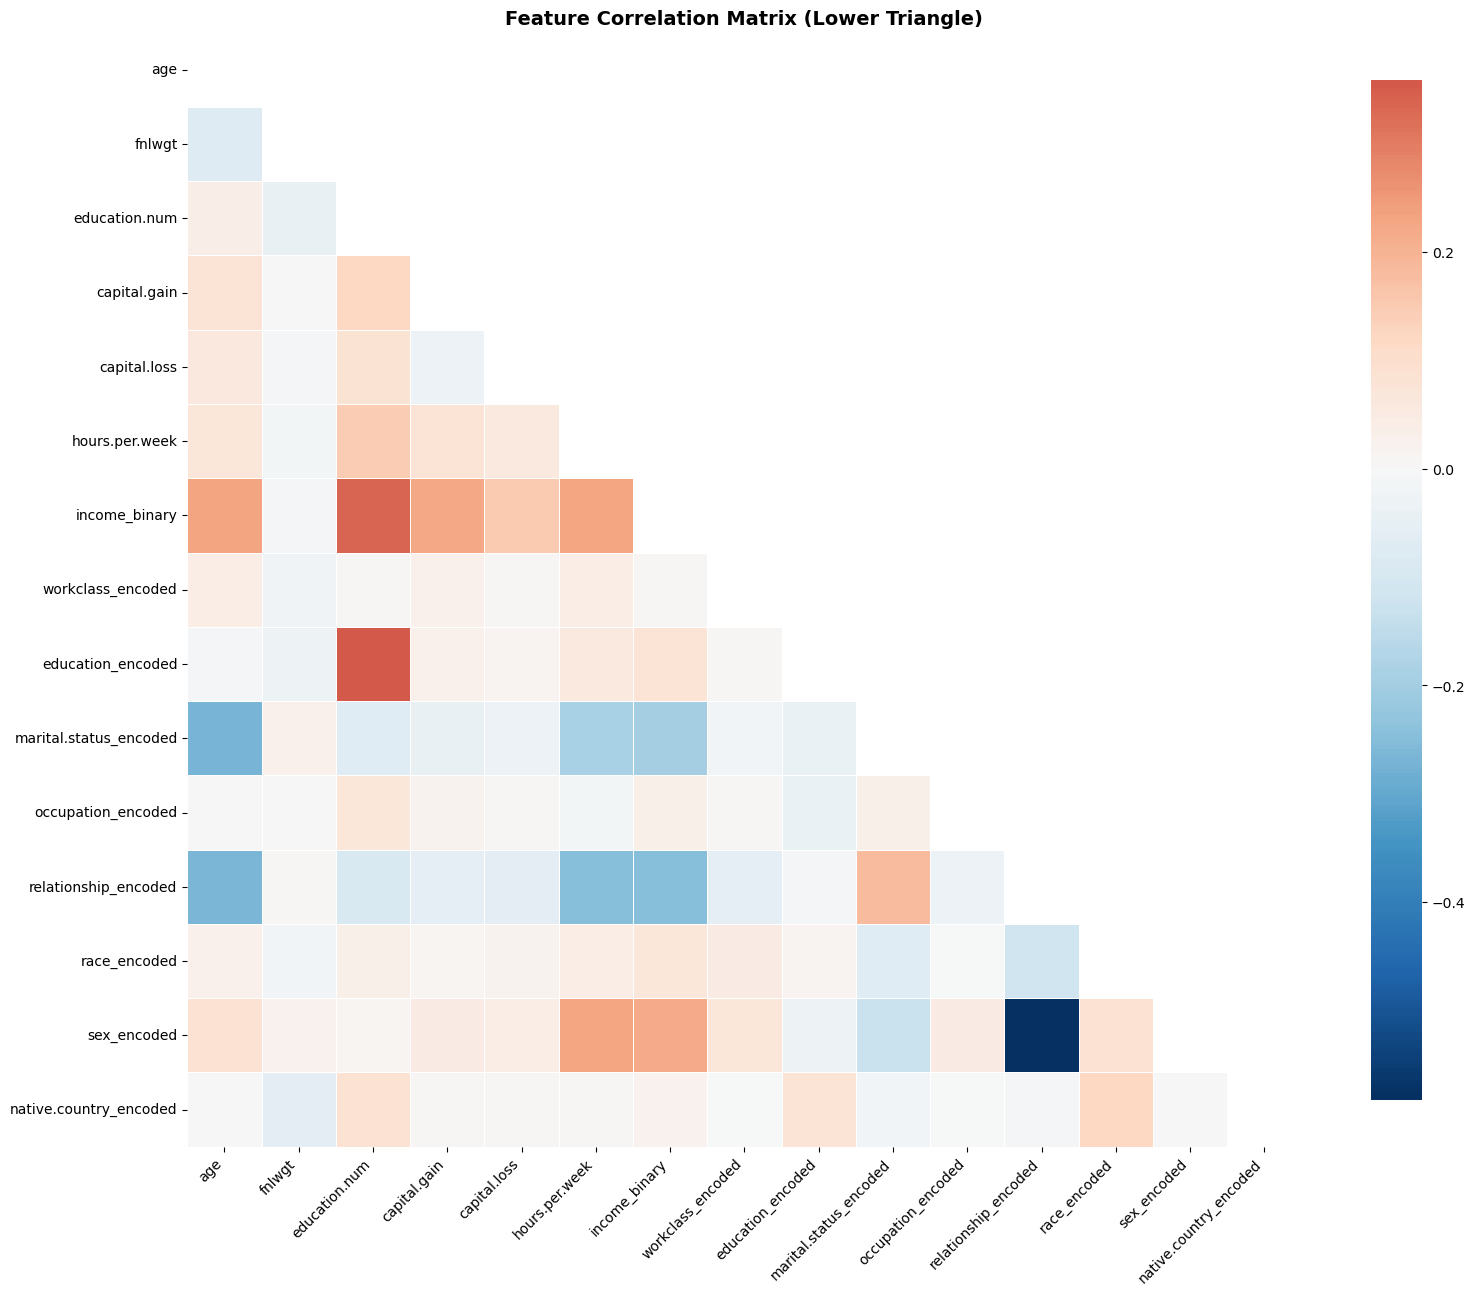

SUCCESS: No high correlations (|r| > 0.7) detected


In [5]:
# Comprehensive correlation matrix
correlation_matrix = df_encoded[all_numeric_cols].corr()

# Visualize correlation matrix with focus on interpretability
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (Lower Triangle)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify high correlations (excluding self-correlations)
high_corr_threshold = 0.7
high_correlations = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > high_corr_threshold:
            high_correlations.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_correlations:
    print(f"\nWARNING: HIGH CORRELATIONS DETECTED (|r| > {high_corr_threshold})")
    print("These may cause multicollinearity issues in neural networks:")
    high_corr_df = pd.DataFrame(high_correlations)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
    
    print("\nNeural Network Recommendations:")
    print("   - Consider feature selection or PCA")
    print("   - Use dropout layers to reduce overfitting")
    print("   - Apply L1/L2 regularization")
    print("   - Monitor for training instability")
else:
    print(f"SUCCESS: No high correlations (|r| > {high_corr_threshold}) detected")


TARGET CORRELATION ANALYSIS
Features ranked by correlation with income (absolute value):
------------------------------------------------------------
education.num                    0.3352 (strong positive)
relationship_encoded            -0.2509 (moderate negative)
age                              0.2340 (moderate positive)
hours.per.week                   0.2297 (moderate positive)
capital.gain                     0.2233 (moderate positive)
sex_encoded                      0.2160 (moderate positive)
marital.status_encoded          -0.1993 (moderate negative)
capital.loss                     0.1505 (moderate positive)
education_encoded                0.0793 (weak positive)
race_encoded                     0.0718 (weak positive)
occupation_encoded               0.0346 (weak positive)
native.country_encoded           0.0231 (weak positive)
fnlwgt                          -0.0095 (weak negative)
workclass_encoded                0.0027 (weak positive)


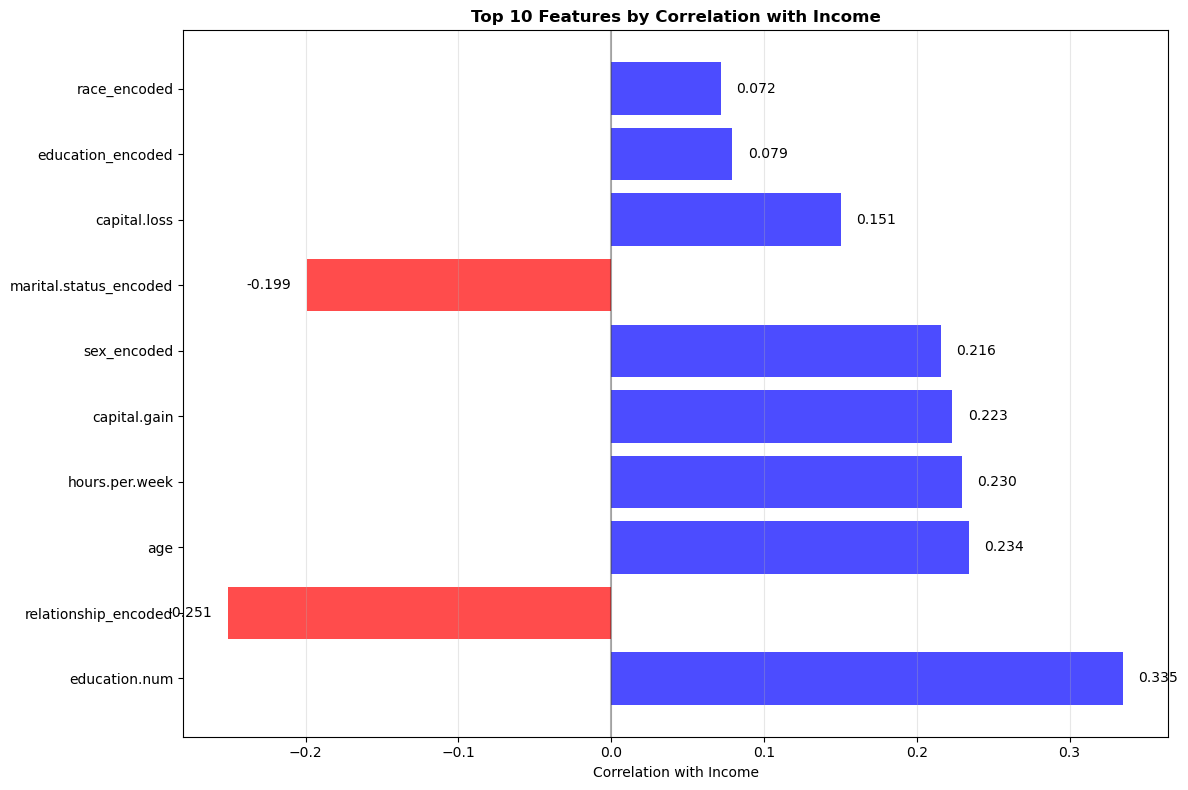


Feature Selection Insights:
   Strong predictors (|r| > 0.3): 1 features
   Moderate predictors (0.1 < |r| <= 0.3): 7 features
   Weak predictors (|r| <= 0.1): 6 features


In [6]:
# Target correlation analysis - Critical for feature importance
print("\nTARGET CORRELATION ANALYSIS")
print("="*40)

target_correlations = correlation_matrix['income_binary'].drop('income_binary').sort_values(key=abs, ascending=False)

print("Features ranked by correlation with income (absolute value):")
print("-" * 60)

for feature, corr in target_correlations.head(15).items():
    direction = "positive" if corr > 0 else "negative"
    strength = "strong" if abs(corr) > 0.3 else "moderate" if abs(corr) > 0.1 else "weak"
    print(f"{feature:30} {corr:8.4f} ({strength} {direction})")

# Visualize top correlations with target
plt.figure(figsize=(12, 8))
top_features = target_correlations.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_features.values]
bars = plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlation with Income')
plt.title('Top 10 Features by Correlation with Income', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_features.values)):
    plt.text(val + (0.01 if val > 0 else -0.01), i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right')

plt.tight_layout()
plt.show()

print(f"\nFeature Selection Insights:")
strong_features = target_correlations[abs(target_correlations) > 0.3]
moderate_features = target_correlations[(abs(target_correlations) > 0.1) & (abs(target_correlations) <= 0.3)]
weak_features = target_correlations[abs(target_correlations) <= 0.1]

print(f"   Strong predictors (|r| > 0.3): {len(strong_features)} features")
print(f"   Moderate predictors (0.1 < |r| <= 0.3): {len(moderate_features)} features")
print(f"   Weak predictors (|r| <= 0.1): {len(weak_features)} features")

## 3. Feature Sparsity and Class Imbalance Analysis

Critical for neural network architecture design:
- Sparse features may require special handling (embeddings)
- Class imbalance affects loss function choice
- Feature sparsity impacts network depth and width decisions

In [7]:
print("FEATURE SPARSITY ANALYSIS")
print("="*40)
print("Analyzing sparsity patterns for neural network design")

# Categorical feature sparsity analysis
categorical_sparsity = []

for col in df.select_dtypes(include=['object']).columns:
    if col != 'income':
        unique_values = df[col].nunique()
        total_samples = len(df)
        
        # Calculate sparsity if we one-hot encode
        value_counts = df[col].value_counts()
        
        # Sparsity = (total_possible_ones - actual_ones) / total_possible_ones
        # For one-hot: each sample has exactly one '1' out of unique_values possibilities
        sparsity = (unique_values - 1) / unique_values
        
        # Most frequent category percentage
        most_frequent_pct = value_counts.iloc[0] / total_samples * 100
        
        categorical_sparsity.append({
            'Feature': col,
            'Unique_Values': unique_values,
            'Sparsity_After_OneHot': sparsity,
            'Most_Frequent_Category_Pct': most_frequent_pct,
            'Recommended_Encoding': 'Embedding' if unique_values > 10 else 'One-Hot'
        })

sparsity_df = pd.DataFrame(categorical_sparsity)
sparsity_df = sparsity_df.sort_values('Sparsity_After_OneHot', ascending=False)

print("\nCategorical Feature Sparsity Analysis:")
print("-" * 80)
print(f"{'Feature':<20} {'Unique':<8} {'Sparsity':<10} {'Top Cat %':<10} {'Encoding':<12}")
print("-" * 80)

for _, row in sparsity_df.iterrows():
    print(f"{row['Feature']:<20} {row['Unique_Values']:<8} "
          f"{row['Sparsity_After_OneHot']:<10.3f} {row['Most_Frequent_Category_Pct']:<10.1f} "
          f"{row['Recommended_Encoding']:<12}")

# Recommendations based on sparsity
high_cardinality = sparsity_df[sparsity_df['Unique_Values'] > 10]
very_sparse = sparsity_df[sparsity_df['Sparsity_After_OneHot'] > 0.9]

print(f"\nNeural Network Encoding Recommendations:")
print(f"   High cardinality features (>10 categories): {len(high_cardinality)} -> Use embeddings")
print(f"   Very sparse features (>90% zeros): {len(very_sparse)} -> Consider embeddings or grouping")

if len(high_cardinality) > 0:
    print(f"   High cardinality features: {high_cardinality['Feature'].tolist()}")
if len(very_sparse) > 0:
    print(f"   Very sparse features: {very_sparse['Feature'].tolist()}")

FEATURE SPARSITY ANALYSIS
Analyzing sparsity patterns for neural network design

Categorical Feature Sparsity Analysis:
--------------------------------------------------------------------------------
Feature              Unique   Sparsity   Top Cat %  Encoding    
--------------------------------------------------------------------------------
native.country       42       0.976      89.6       Embedding   
education            16       0.938      32.3       Embedding   
occupation           15       0.933      12.7       Embedding   
workclass            9        0.889      69.7       One-Hot     
marital.status       7        0.857      46.0       One-Hot     
relationship         6        0.833      40.5       One-Hot     
race                 5        0.800      85.4       One-Hot     
sex                  2        0.500      66.9       One-Hot     

Neural Network Encoding Recommendations:
   High cardinality features (>10 categories): 3 -> Use embeddings
   Very sparse features 

## 4. Feature Interactions Analysis

Neural networks excel at learning complex feature interactions. Let's explore key interactions:
- Education × Hours per week
- Occupation × Capital gains
- Age × Education level
- Marital status × Gender

In [8]:
print("FEATURE INTERACTIONS ANALYSIS")
print("="*50)
print("Exploring complex relationships that neural networks can capture")

# Clean data for interaction analysis
df_clean = df.copy()
df_clean = df_clean.replace('?', np.nan)

# Fill missing values
for col in df_clean.select_dtypes(include=['object']).columns:
    if df_clean[col].isnull().any():
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)

# Create binary target
df_clean['high_income'] = (df_clean['income'] == '>50K').astype(int)

print(f"Data prepared for interaction analysis: {df_clean.shape}")
print(f"Missing values remaining: {df_clean.isnull().sum().sum()}")

FEATURE INTERACTIONS ANALYSIS
Exploring complex relationships that neural networks can capture
Data prepared for interaction analysis: (32561, 16)
Missing values remaining: 0



1. EDUCATION × HOURS PER WEEK INTERACTION
High income rate by Education × Hours worked:
hours_group      Part-time (<20h)  Reduced (20-35h)  Standard (35-45h)  \
education_group                                                          
Bachelor+                   0.208             0.311              0.452   
High School                 0.042             0.056              0.159   
Low                         0.003             0.024              0.064   
Some College                0.063             0.065              0.214   

hours_group      Overtime (45-60h)  Extreme (>60h)  
education_group                                     
Bachelor+                    0.640           0.576  
High School                  0.271           0.266  
Low                          0.136           0.146  
Some College                 0.368           0.306  


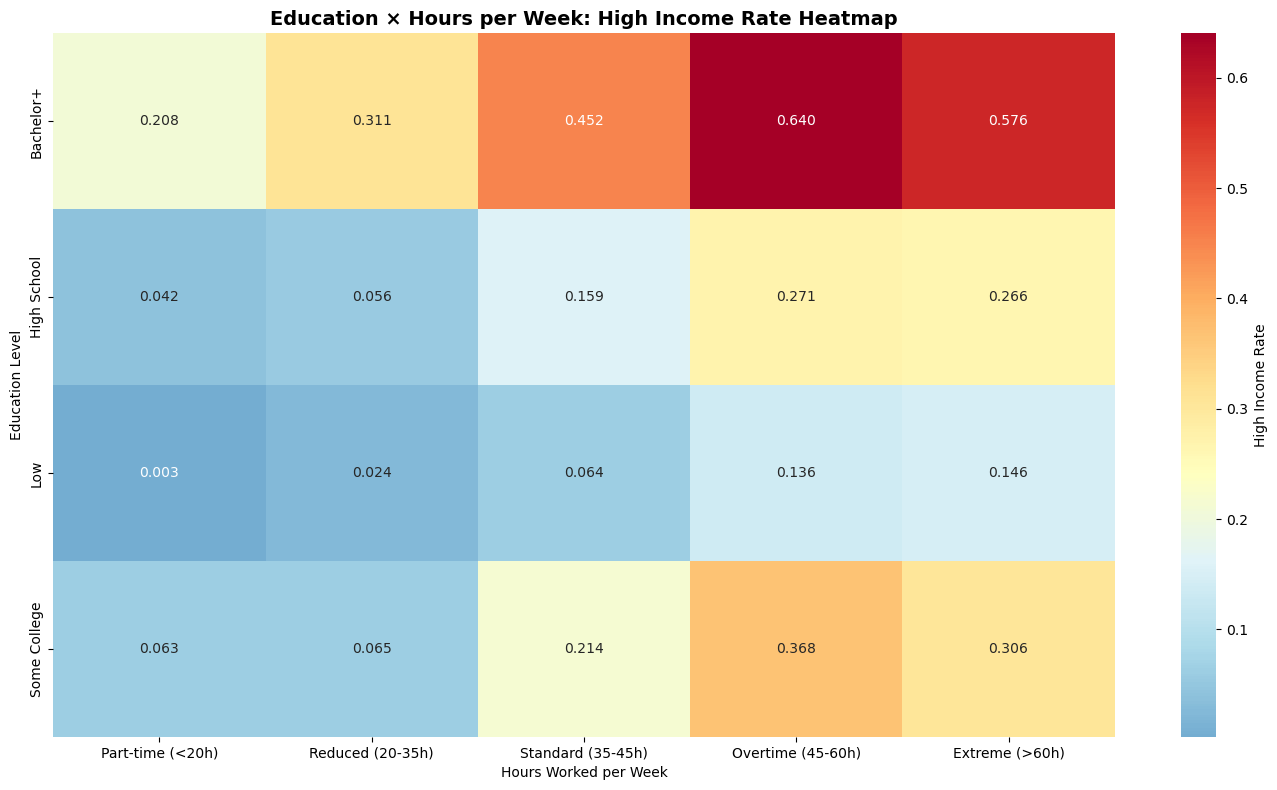


Key Interaction Insights:
   Highest income rate: 0.640 (Bachelor+ × Overtime (45-60h))
   Lowest income rate: 0.003 (Low × Part-time (<20h))
   Interaction range: 0.637
   Strong interaction detected! Neural networks should capture this.


In [9]:
# 1. Education × Hours per week interaction
print("\n1. EDUCATION × HOURS PER WEEK INTERACTION")
print("="*50)

# Create education level groups for better visualization
education_groups = {
    'Low': ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th'],
    'High School': ['HS-grad'],
    'Some College': ['Some-college', 'Assoc-acdm', 'Assoc-voc'],
    'Bachelor+': ['Bachelors', 'Masters', 'Doctorate', 'Prof-school']
}

def map_education_group(education):
    for group, levels in education_groups.items():
        if education in levels:
            return group
    return 'Other'

df_clean['education_group'] = df_clean['education'].apply(map_education_group)

# Create hours worked groups
df_clean['hours_group'] = pd.cut(df_clean['hours.per.week'], 
                                bins=[0, 20, 35, 45, 60, 100],
                                labels=['Part-time (<20h)', 'Reduced (20-35h)', 
                                       'Standard (35-45h)', 'Overtime (45-60h)', 
                                       'Extreme (>60h)'])

# Analyze interaction
edu_hours_interaction = pd.crosstab([df_clean['education_group'], df_clean['hours_group']], 
                                   df_clean['high_income'], normalize='index')

print("High income rate by Education × Hours worked:")
if 1 in edu_hours_interaction.columns:
    interaction_matrix = edu_hours_interaction[1]
    interaction_pivot = interaction_matrix.unstack(level=1)
    print(interaction_pivot.round(3))
    
    # Visualize the interaction
    plt.figure(figsize=(14, 8))
    sns.heatmap(interaction_pivot, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                center=df_clean['high_income'].mean(), cbar_kws={'label': 'High Income Rate'})
    plt.title('Education × Hours per Week: High Income Rate Heatmap', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Hours Worked per Week')
    plt.ylabel('Education Level')
    plt.tight_layout()
    plt.show()
    
    # Find strongest interactions
    max_rate = interaction_pivot.max().max()
    min_rate = interaction_pivot.min().min()
    
    max_idx = interaction_pivot.stack().idxmax()
    min_idx = interaction_pivot.stack().idxmin()
    
    print(f"\nKey Interaction Insights:")
    print(f"   Highest income rate: {max_rate:.3f} ({max_idx[0]} × {max_idx[1]})")
    print(f"   Lowest income rate: {min_rate:.3f} ({min_idx[0]} × {min_idx[1]})")
    print(f"   Interaction range: {max_rate - min_rate:.3f}")
    
    if max_rate - min_rate > 0.3:
        print(f"   Strong interaction detected! Neural networks should capture this.")

## 5. Deep Learning Data Preparation

Based on our analysis, here are the key recommendations for neural network design:

In [10]:
# Create a sample preprocessing pipeline for deep learning
print("DEEP LEARNING PREPROCESSING PIPELINE")
print("="*50)

# Demonstrate the preprocessing approach
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Prepare the data
df_ml = df.copy()
df_ml = df_ml.replace('?', np.nan)

# Handle missing values
for col in df_ml.select_dtypes(include=['object']).columns:
    if df_ml[col].isnull().any():
        mode_val = df_ml[col].mode()[0]
        df_ml[col].fillna(mode_val, inplace=True)

# Separate features by type
numerical_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'education', 'marital.status', 'occupation', 
                       'relationship', 'race', 'sex', 'native.country']

# Create target variable
y = (df_ml['income'] == '>50K').astype(int)

print(f"Features for neural network:")
print(f"  Numerical features: {len(numerical_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  Total features: {len(numerical_features) + len(categorical_features)}")

# Encode categorical features for analysis
le_dict = {}
X_categorical = df_ml[categorical_features].copy()

for col in categorical_features:
    le = LabelEncoder()
    X_categorical[col] = le.fit_transform(X_categorical[col])
    le_dict[col] = le
    print(f"  {col}: {len(le.classes_)} classes (max: {X_categorical[col].max()})")

# Scale numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df_ml[numerical_features])

print(f"\nNumerical features scaled to mean=0, std=1")
print(f"Shape: {X_numerical.shape}")
print(f"Categorical features encoded")
print(f"Shape: {X_categorical.shape}")

# Train-test split
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_numerical, X_categorical, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain-test split completed:")
print(f"  Training samples: {len(X_num_train):,}")
print(f"  Test samples: {len(X_num_test):,}")
print(f"  Class distribution in training: {np.bincount(y_train)}")

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"\nClass weights for balanced training: {class_weight_dict}")
print(f"\nData preprocessing pipeline ready for neural network training!")

DEEP LEARNING PREPROCESSING PIPELINE
Features for neural network:
  Numerical features: 6
  Categorical features: 8
  Total features: 14
  workclass: 8 classes (max: 7)
  education: 16 classes (max: 15)
  marital.status: 7 classes (max: 6)
  occupation: 14 classes (max: 13)
  relationship: 6 classes (max: 5)
  race: 5 classes (max: 4)
  sex: 2 classes (max: 1)
  native.country: 41 classes (max: 40)

Numerical features scaled to mean=0, std=1
Shape: (32561, 6)
Categorical features encoded
Shape: (32561, 8)

Train-test split completed:
  Training samples: 26,048
  Test samples: 6,513
  Class distribution in training: [19775  6273]

Class weights for balanced training: {0: 0.6586093552465234, 1: 2.076199585525267}

Data preprocessing pipeline ready for neural network training!


In [15]:
# Save preprocessing artifacts for neural network training
import joblib
from pathlib import Path

# Create directory for deep learning artifacts
Path('deep_learning_data').mkdir(exist_ok=True)

# Save preprocessed data
np.save('deep_learning_data/X_numerical_train.npy', X_num_train)
np.save('deep_learning_data/X_numerical_test.npy', X_num_test)
np.save('deep_learning_data/X_categorical_train.npy', X_cat_train.values)
np.save('deep_learning_data/X_categorical_test.npy', X_cat_test.values)
np.save('deep_learning_data/y_train.npy', y_train)
np.save('deep_learning_data/y_test.npy', y_test)

# Save preprocessing objects
joblib.dump(scaler, 'deep_learning_data/numerical_scaler.pkl')
joblib.dump(le_dict, 'deep_learning_data/categorical_encoders.pkl')
joblib.dump(class_weight_dict, 'deep_learning_data/class_weights.pkl')

# Convert numpy types to Python native types for JSON serialization
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(item) for item in obj)
    else:
        return obj

# Save feature names and metadata
metadata = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'categorical_cardinalities': {col: int(len(le.classes_)) for col, le in le_dict.items()},
    'class_weights': {int(k): float(v) for k, v in class_weight_dict.items()},
    'dataset_shape': [int(x) for x in df.shape],
    'class_distribution': {str(k): int(v) for k, v in df['income'].value_counts().items()}
}

# Convert all numpy types to Python native types
metadata = convert_numpy_types(metadata)

import json
with open('deep_learning_data/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nDEEP LEARNING EDA COMPLETED SUCCESSFULLY!")
print("="*50)
print("Files saved for neural network training:")
print("  - Preprocessed training and test data")
print("  - Numerical feature scaler")
print("  - Categorical encoders")
print("  - Class weights for balanced training")
print("  - Feature metadata and recommendations")
print("\nReady to build and train neural networks!")


DEEP LEARNING EDA COMPLETED SUCCESSFULLY!
Files saved for neural network training:
  - Preprocessed training and test data
  - Numerical feature scaler
  - Categorical encoders
  - Class weights for balanced training
  - Feature metadata and recommendations

Ready to build and train neural networks!
